# Rotation curve

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize
from scipy import interpolate
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import config as cfg
from galpy.potential.mwpotentials import MWPotential2014
from galpy.potential import TriaxialNFWPotential,PowerSphericalPotentialwCutoff,MiyamotoNagaiPotential
from galpy.potential import plotRotcurve
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import argrelextrema
import potential_classes as pot
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3558868/1711622817.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_Eilers = pd.read_csv('vel_Eilers.txt', sep="  ")

/home/mmestre/.conda/envs/cosmos/lib/python3.9/site-packages/galpy/potential/Potential.py:1147: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(R*-self.Rforce(R,0.,phi=phi,t=t,use_physical=False))

Rar: V_c(R_sun)= 244.04266713027297
Bovy: V_circ(R_sun)= 219.66116090141963
Malhan: V_circ(R_sun)= 244.8640544928808
/tmp/ipykernel_3558868/1711622817.py:95: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(0.5*c*c*r*halo.dnu(r))

arg_max= (array([356, 936]),)
r_cand = 1.3908557324401478e-28
m_cand = 3521127.9267396056
r_core = 1.384628880815053e-28  kpc
m_core = 3505470.972489524  M_sun


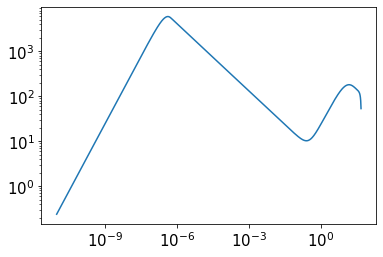

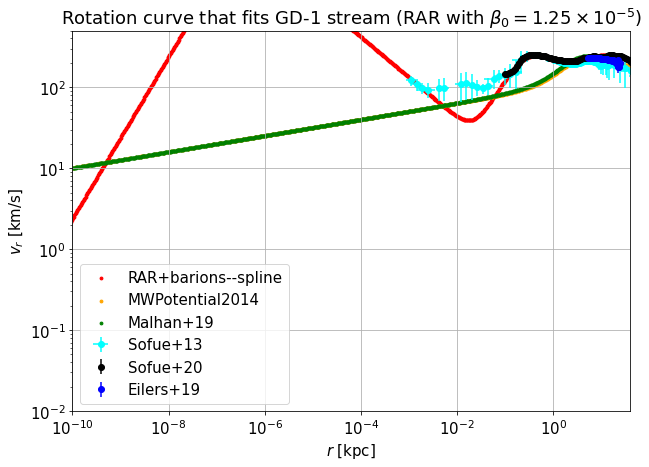

In [6]:
# Rotation velocity

c=2.997925e5  # km s^-1
kpc2cm = 3.0856776e+21 #cm/kpc
sec2rad = np.pi/(180.*60**2)
cm2kpc = 1.0/kpc2cm


def accel_mw(x,y,z):
    return bulge.accel(x,y,z)+thin.accel(x,y,z)+thick.accel(x,y,z)+halo.accel(x,y,z)
    # return halo.accel(x,y,z)

def grad_mw(x,y,z):
    return -accel_mw(x,y,z)

def rot_vel_mw(r):
    return np.sqrt(r*(grad_mw(r,0,0)[0]))

def galpy_vcirc(r):
    mwp = MWPotential2014
    a= mwp[0].vcirc(r*u.kpc)
    b= mwp[1].vcirc(r*u.kpc)
    c= mwp[2].vcirc(r*u.kpc)
    return np.sqrt(a*a+b*b+c*c)*220.0

def malhan_vcirc(r):
    bp= PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/8.,normalize=0.05)
    mp= MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=.6)
    hp=TriaxialNFWPotential(a=16.0/8.,b=1.0,c=0.82,normalize=0.59)
    mw = bp+mp+hp
    v0=mw[0].vcirc(r*u.kpc)
    v1=mw[1].vcirc(r*u.kpc)
    v2=mw[2].vcirc(r*u.kpc)
    return np.sqrt(v0*v0+v1*v1+v2*v2)*220.0

# Set rotation data
exec(open("./vel_Sofue13.py").read())
v_Sof20=pd.read_csv('vel_Sofue20.txt', sep=" ")
v_Eilers = pd.read_csv('vel_Eilers.txt', sep="  ")
asym_error = [v_Eilers['e_down'], v_Eilers['e_up']]

# Set barionic potentials
M_gal=2.32e7  # Msun
bulge = pot.Plummer(460.0*M_gal,0.3)
# thin = pot.MiyamotoNagai(1700.0*M_gal,5.3,0.25)
# thick= pot.MiyamotoNagai(1700.0*M_gal,2.6,0.8)
# Changing the disk paramters according to "fit_pot-slice-barions_..."
[alpha, scale, scaleb] = [1.082285264900089583e+00, 9.162718188400553743e-01, 9.006049804965896577e-01]
thin = pot.MiyamotoNagai(1700.0*M_gal*alpha, 5.3*scale, 0.25*scaleb)
thick = pot.MiyamotoNagai(1700.0*M_gal*alpha, 2.6*scale, 0.8*scaleb)


# Set halo potential
ener_f = 56.0  # keV
# theta_0, W_0, beta_0 = 3.77780827e+01, 6.63468885e+01, 1.20446329e-05
# theta_0 = 3.555983357444605275e+01
# W_0 = theta_0 + 2.695065692279481695e+01
# theta_0 = 3.623511473208260014e+01
# W_0 = theta_0 + 2.745737545624503895e+01
# theta_0 = 3.595711139271328705e+01
# W_0 = theta_0 + 2.725291292672873666e+01
# beta_0 = 1.1977e-5
# beta_0 = 1.20446329e-05
theta_0, d_theta = 3.801447492884311430e+01, 2.876435599599692239e+01
beta_0 = 1.25e-5

# List of solutions from GD-1 fit (Crests of maximums.)
# beta_0 = 1.0e-5
# theta_0, d_theta = 36.5310621242485, 27.687374749498996
# beta_0 = 1.2e-05
# theta_0, d_theta = 36.28657314629258, 27.494989979959918
# beta_0 = 1.3000000000000001e-05 
# theta_0, d_theta = 36.22244488977956, 27.442885771543086
# beta_0 =1.5e-05 
# theta_0, d_theta = 36.02204408817635, 27.286573146292586
W_0 = theta_0+d_theta
param = np.array([ener_f,theta_0, W_0, beta_0 ])  
halo = pot.RAR(param)


# Compute circular velocities
r_vec=np.logspace(-11,2,1000)
v_vec = [rot_vel_mw(x) for x in r_vec]
v_galpy = [galpy_vcirc(x) for x in r_vec]
v_malhan = [malhan_vcirc(x) for x in r_vec]
print('Rar: V_c(R_sun)=',rot_vel_mw(8.122))
print('Bovy: V_circ(R_sun)=', galpy_vcirc(8.122))
print('Malhan: V_circ(R_sun)=', malhan_vcirc(8.122))


def v_circ_gr(r):
    return np.sqrt(0.5*c*c*r*halo.dnu(r))

def get_core(r):
    arg_max = argrelextrema(v_circ_gr(r), np.greater)
    print('arg_max=',arg_max)
    arg_first_max = arg_max[0][0]
    r_cand = r[arg_first_max]
    bounds=np.array([r_cand*0.5,r_cand*1.5])
    r_core=optimize.fminbound(lambda r: -v_circ_gr(r),bounds[0],bounds[1],xtol=0.5e-14,maxfun=1000)
    m_core=halo.mass_spline(r_core)
    print('r_cand =', r_cand*cm2kpc)
    print('m_cand =', halo.mass_spline(r_cand))
    print('r_core =', r_core*cm2kpc,' kpc')
    print('m_core =', m_core, ' M_sun')
    plt.plot(r, v_circ_gr(r))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    return r_core, m_core

get_core(r_vec)

# Plot
fig = plt.figure(figsize=(10,7))
font = {"size": 15}  
plt.rc('font', **font)
plt.scatter(r_vec,v_vec,s=8,marker='o', color='red', label='RAR+barions--spline')
plt.scatter(r_vec,v_galpy,s=8,marker='o', color='orange',label='MWPotential2014')
plt.scatter(r_vec,v_malhan,s=8,marker='o', color='green',label='Malhan+19')
# plt.scatter(r_vec,v_circ_gr(r_vec), s=8,marker='o', color='violet',label='halo with dnu')
plt.errorbar(v_Sof['r']/1.e3, v_Sof['v'], xerr=v_Sof['err_r']/1.e3 ,yerr=v_Sof['err_v'], fmt='o', color='cyan', label='Sofue+13')
plt.errorbar(v_Sof20['Radius'],v_Sof20['Velocity'],yerr=v_Sof20['Error'],fmt='o',color='black',label='Sofue+20')
plt.errorbar(v_Eilers['r'],v_Eilers['v'],yerr=asym_error,fmt='o',color='blue',label='Eilers+19')
plt.xlim(1.e-10,40)
plt.ylim(1.e-2,500)
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$v_r$ [km/s]')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title(r'Rotation curve that fits GD-1 stream (RAR with $\beta_0=1.25\times 10^{-5}$)')
plt.savefig('plots/rotation_curve_beta0_1.25e-5.png')

In [5]:
print(2**10,10**4)

1024 10000
